# Final Project: Grouping Foreign-Language Words into Topics

## Problem Statement

I am building a language learning app and would like to have a way to categorize words into different topics for language learning. It is easy to get words by level of difficulty because many standardized language tests have vocabulary lists. However, while those lists do a great job of setting expectations for different fluency levels, grouping by difficulty is not necessarily conducive to learning vocabulary. Instead, it can be very helpful to group words by topic so that the learner can more easily associate words; additionally, some users care more about certain subsets of vocabulary than others. For example, a student doing a foreign internship will care more about "business" words than somebody who is vacationing --they might care more about "food and drink." 

**I will only be doing the Spanish language.**

In [1]:
import pandas as pd
import numpy as np
import requests
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from collections import Counter
import math
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
import scipy.sparse as sp
import topicwizard
from topicwizard.pipeline import make_topic_pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
import warnings

## The Data

Wikipedia has a gigantic corpus of text with [classifications](https://en.wikipedia.org/wiki/Category:Main_topic_classifications) (Wikipedia contributors, n.d.). The corpus is too large and often too specific or not specific enough for my purposes, so the categories I query must be manually passed. The categories I select will be categories that I believe would be broadly helpful to language learners.

Because I am fetching the data, I will keep the classes balanced to improve model accuracy.

Wikipedia is a well-organized website with quality checks --at least for popular languages-- so I will assume that the spelling of words is correct.

### Gathering Some Data

In [2]:
def get_category_article_count(category, language="es", category_prefix="Categoría"):
    url = f"https://{language}.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "list": "categorymembers",
        "cmtitle": f"{category_prefix}:{category}",
        "cmlimit": "max"
    }

    response = requests.get(url, params=params)
    data = response.json()
    return len(data.get("query", {}).get("categorymembers", []))

In [3]:
# Test
category = "Religión"
language = "es"
article_count = get_category_article_count(category, language)
print(f"Number of articles in the category '{category}' in language '{language}' {article_count}")

Number of articles in the category 'Religión' in language 'es' 48


In [4]:
def fetch_wikipedia_articles( language='es', category_prefix='Categoría', category='Religión', number_of_articles=3, preview_length=300):
    """
    Fetch articles from a specific Wikipedia category in a given language.
    
    Args:
        language (str): Language code (e.g., 'es' for Spanish, 'en' for English).
        category_prefix (str): Prefix for the category (e.g., "Category" or "Categoría"). Note: casing doesn't matter.
        category (str): Category name ("Religion" or "Religión"). Note: accents matter, casing generally matters.
        number_of_articles (int): Number of articles to fetch.
        preview_length (int): Number of characters to display from each article.
    """
    base_url = f"https://{language}.wikipedia.org/w/api.php"
    
    # Combine prefix and category (no encoding, user must ensure correctness)
    cmtitle = f"{category_prefix}:{category}"
    
    category_params = {
        "action": "query",
        "list": "categorymembers",
        "cmtitle": cmtitle,
        "cmlimit": number_of_articles,
        "format": "json"
    }
    
    try:
        print(f"Fetching up to {number_of_articles} articles from '{cmtitle}' in {language}...\n")
        
        response = requests.get(base_url, params=category_params)
        response.raise_for_status()
        data = response.json()
        
        articles = data.get("query", {}).get("categorymembers", [])
        
        if not articles:
            print(f"No articles found in '{cmtitle}' in {language}.")
            return
        
        results = []
        for article in articles:
            title = article['title']
            
            content_params = {
                "action": "query",
                "prop": "extracts",
                "titles": title,
                "explaintext": True,
                "format": "json"
            }
            
            content_response = requests.get(base_url, params=content_params)
            content_response.raise_for_status()
            content_data = content_response.json()
            
            pages = content_data.get("query", {}).get("pages", {})
            for page_id, page_info in pages.items():
                result = {
                    'title': page_info.get('title'),
                    'extract': page_info.get('extract', 'No content available'),
                    'url': f"https://{language}.wikipedia.org/wiki/{title.replace(' ', '_')}"
                }
                results.append(result)
        
        for i, result in enumerate(results, 1):
            display(HTML(f"Article {i}: <a href='{result['url']}' target='_blank'>{result['title']}</a>"))
            display(HTML(f"{result['extract'][:preview_length]}...<br><br>"))

            
        return results
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from Wikipedia API: {e}")
        return None

In [5]:
# Testing Spanish
articles = fetch_wikipedia_articles()

Fetching up to 3 articles from 'Categoría:Religión' in es...



In [6]:
# Testing English
en_articles = fetch_wikipedia_articles(language='en', category_prefix = 'Category', category='Religion', number_of_articles=3, preview_length=100)

Fetching up to 3 articles from 'Category:Religion' in en...



### Manually Inspecting and Cleaning the Data

In [7]:
articles[2]['extract']

"Abu Bakr Ahmad ibn Musa ibn al-Abbas ibn Mujahid al-Atashi (en árabe: أبو بكر أحمد بن موسى بن العباس بن مجاهد التميمي\u200e, romanizado: Abū Bakr Aḥmad ibn Mūsā ibn al-ʿAbbās Ibn Mujāhid al-ʿAṭashī ) (245-324 año de la Hégira/859 o 860-936 EC) fue un erudito islámico, más conocido por establecer y delinear las siete lecturas coránicas canónicas (qira'at) en su obra Kitāb al-sabʿa fī l-qirāʾāt.[1]\u200b También se destacó por entregar el cargo de exégesis herética del Corán que reabrió el juicio de Mansur al-Hallaj, que finalmente condujo a su ejecución por orden del califa abasí al-Muqtadir.[2]\u200b\n\n\n== Biografía ==\nIbn Mujahid nació en Bagdad el 859 o 860 EC/245 AH, donde estudió el hadiz y el Corán.[1]\u200b Aprendió esto último de Muhammad ibn Ahmad al-Dajuni[1]\u200b y Qunbul,  ambos transmisores de sus lecturas canónicas posteriores. Se desconoce a qué escuela de jurisprudencia islámica se adscribió Ibn Mujahid, aunque expresó admiración por la escuela Shafi'i . Se convirti

Although I am assuming a quality resource like Wikipedia to have correct spelling, there is still a lot of cleaning that needs to be done, including:
- Whitespace
- Citation references
- Wikipedia section headers
- Non-Latin characters, such as Arabic
- Punctuation
- Useless information at the end of articles, ex "Enlaces externos"
    - Actually, I changed my mind on this. This section can have high predictabilty features because they link to similar things

The Wikipedia will return empty strings for articles that are not actually articles. For example, articles[1] has a valid URL that returns a page with text. However, it is the portal page for religion, so it itself is not an article on a topic. For my purposes, this behavior is okay!

In [8]:
articles[1]

{'title': 'Portal:Religión',
 'extract': '',
 'url': 'https://es.wikipedia.org/wiki/Portal:Religión'}

In [9]:
import re

def clean_text(text, cutoff=None):
    '''
    This takes a text string and cleans it, returning it in all lowercase.

    Args:
        text (str): Input text to be cleaned
        cutoff (str): The string after which the text will be truncated. The default is "Véase también".
                          All content after and including this string will be removed from the text. 
                          The function is case-insensitive and handles multiple lines.

    Removes:
        - Text after the specified cutoff string. Default: None.
        - Citation references (text inside square brackets like [6]).
        - Wikipedia section headers (text between "==" symbols).
        - Special characters, leaving only Latin characters, numbers, and spaces.
    '''
    if cutoff:
        text = re.sub(r'{}.*'.format(re.escape(cutoff)), '', text, flags= re.DOTALL) # Remove everything after "Véase también" (case-insensitive)
    
    text = re.sub(r'\[\d+\]', '', text)  # Remove citation references (i.e., text inside square brackets like [6])
    text = re.sub(r'==.*?==', '', text)  # Remove Wikipedia section headers (i.e., Biografía)
    
    text = re.sub(r'[^A-Za-zÀ-ÿ0-9\s]', '', text)  # Keep only Latin characters, numbers, and spaces. 
                                                    #This will remove hyphenated words too but I find that acceptable
    
    # Because I will be using a lemmatizer or stemmer, removing the whitespace in this step would duplicate work
    #text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    return text.lower()


cleaned_text = clean_text(articles[2]['extract'])
print(cleaned_text)

abu bakr ahmad ibn musa ibn alabbas ibn mujahid alatashi en árabe           romanizado ab bakr amad ibn ms ibn alabbs ibn mujhid alaash  245324 año de la hégira859 o 860936 ec fue un erudito islámico más conocido por establecer y delinear las siete lecturas coránicas canónicas qiraat en su obra kitb alsaba f lqirt también se destacó por entregar el cargo de exégesis herética del corán que reabrió el juicio de mansur alhallaj que finalmente condujo a su ejecución por orden del califa abasí almuqtadir



ibn mujahid nació en bagdad el 859 o 860 ec245 ah donde estudió el hadiz y el corán aprendió esto último de muhammad ibn ahmad aldajuni y qunbul  ambos transmisores de sus lecturas canónicas posteriores se desconoce a qué escuela de jurisprudencia islámica se adscribió ibn mujahid aunque expresó admiración por la escuela shafii  se convirtió en un renombrado especialista en las lecturas coránicas el tamaño de su círculo de estudio se da entre 84 y 300 estudiantes y ayudó al visir abasí a

### Gathering All the Data

The categories I have chosen are:
1) Religion (Religión)
2) Soccer (Fútbol)
3) Football (Fútbol Americano)
4) Pop Music (Pop)
5) Film (Cine)
6) Government (Gobierno)
7) Playability of Video Games (Jugabilidad de videojuegos)
8) Pop Culture (Cultura popular)
9) Dance (Danza)
10) Human Appearance (Apariencia humana)
11) Family Relationships (Parentescos)
12) Rights (Derechos)

My only selection criteria for the categories were: 
- Over 15 Wikipedia articles
- Would be helpful as a language learning topic --not esoteric.

In [10]:
test = fetch_wikipedia_articles(category='derechos', number_of_articles=20, preview_length=130)

Fetching up to 20 articles from 'Categoría:derechos' in es...



In [11]:
categories = [
    "Apariencia humana",
    "Cine",
    "Cultura popular",
    "Danza",
    "Derechos",
    "Fútbol",
    "Fútbol americano",
    "Gobierno",
    "Jugabilidad de videojuegos",
    "Parentescos",
    "Pop",
    "Religión"
]

language = 'es'
for category in categories:
    article_count = get_category_article_count(category, language)
    print(f"{article_count} articles in category '{category}'")

24 articles in category 'Apariencia humana'
181 articles in category 'Cine'
83 articles in category 'Cultura popular'
60 articles in category 'Danza'
35 articles in category 'Derechos'
34 articles in category 'Fútbol'
19 articles in category 'Fútbol americano'
86 articles in category 'Gobierno'
62 articles in category 'Jugabilidad de videojuegos'
70 articles in category 'Parentescos'
38 articles in category 'Pop'
48 articles in category 'Religión'


The maximum difference is 181 articles (Cine) vs 19 articles (Fútbol americano). This is a ratio of 9.5:1 which might be acceptable to not worry about class imbalance. However, compared to the second-biggest category it is not so bad: 86 articles in Gobierno. Additionally, I expect the Cine (movie) category to be rather distinct so I will not limit the amount of articles pulled --I will pull all available.

In [12]:
# # Pull the data
# data = pd.DataFrame()
# for category in categories:
#     category_articles = fetch_wikipedia_articles(category=category, number_of_articles=200, preview_length=30) 
#     category_df = pd.json_normalize(category_articles)
#     category_df['category'] = category
#     data = pd.concat([data, category_df], ignore_index=True)

# data = data.dropna()
# data.to_excel("wiki_articles.xlsx", index=False, engine="openpyxl")

In [13]:
data = pd.read_excel("wiki_articles.xlsx")

### Extra Cleaning

In [14]:
# Articles that just say Categoría are often empty and not articles themselves
data = data[~data['title'].str.contains("Categoría:|Portal", na=False)]

In [15]:
data[data.isna().any(axis=1)].head(5)

,title,extract,url,category
585,Abuela,NaN,https://es.wikipedia.org/wiki/Abuela,Parentescos
587,Bichozna,NaN,https://es.wikipedia.org/wiki/Bichozna,Parentescos
588,Bichozno,NaN,https://es.wikipedia.org/wiki/Bichozno,Parentescos
589,Bisabuela,NaN,https://es.wikipedia.org/wiki/Bisabuela,Parentescos
590,Bisabuelo,NaN,https://es.wikipedia.org/wiki/Bisabuelo,Parentescos


In [16]:
# The rest of the NaN's are just articles that have not been written for different family relationships. Like "granda" or "great grandmother"
data = data.dropna()

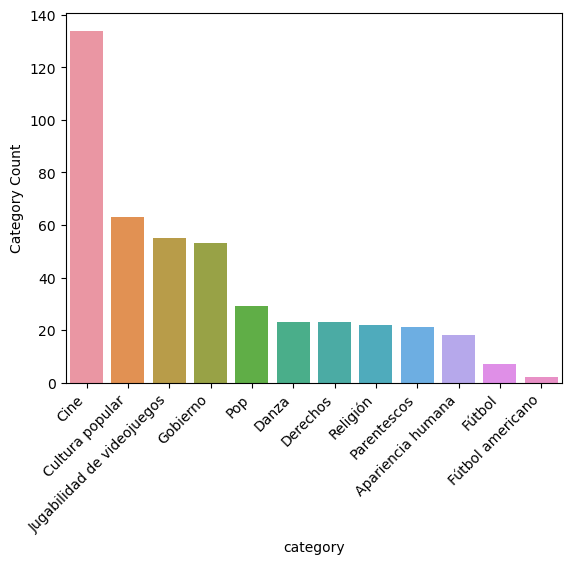

In [17]:
sns.barplot(
    data=data.groupby("category").size().reset_index(name="Category Count").sort_values("Category Count", ascending=False), 
    x="category", 
    y="Category Count"
)
plt.xticks(rotation=45, ha='right')
plt.show()

In [18]:
data["category"].value_counts()

category
Cine                          134
Cultura popular                63
Jugabilidad de videojuegos     55
Gobierno                       53
Pop                            29
Danza                          23
Derechos                       23
Religión                       22
Parentescos                    21
Apariencia humana              18
Fútbol                          7
Fútbol americano                2
Name: count, dtype: int64

After cleaning out the nan's, there is not enough articles in Fútbol and Fútbol americano, even if they are combined to a broader "sports" category. So, I will drop these categories.

In [19]:
data = data[~data["category"].isin(["Fútbol", "Fútbol americano"])]
categories = data["category"].unique()

### EDA

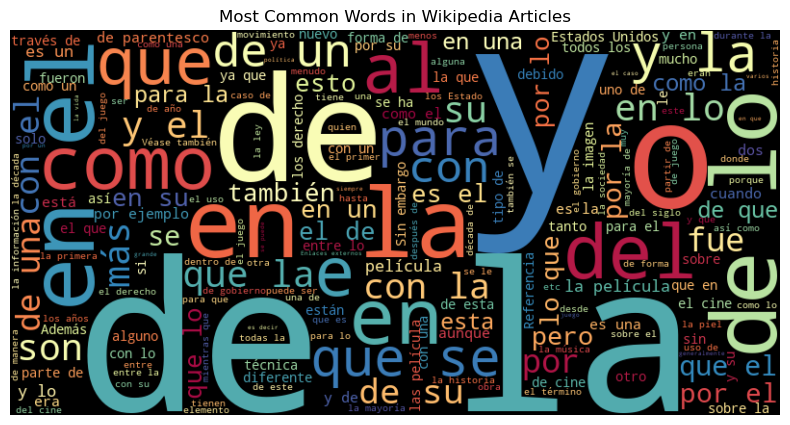

In [20]:
all_words = " ".join(data['extract'].fillna('').astype(str)) #*
wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="Spectral").generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Wikipedia Articles")
plt.show()

del all_words

Most of the word clouds words are just functional words, like the English equivalents of "the," "and," "in," etc. These are not very useful for my purposes. And, while stemming is faster, stemmed words are also not useful for my language learning app, so lemmatized words will be used because they will convert words into their dictionary format! This does come at the cost of computation though.

In [21]:
nlp = spacy.load("es_core_news_sm")
stop_words = set(stopwords.words("spanish"))

def preprocess_text(text, cutoff=None):
    '''
    *** BECAUSE SPANISH HAS ITS OWN LEMMATIZER, FUTURE LANGUAGES WILL NEED TO USE A DIFFERENT LEMMATIZER! ***
    
    Uses the clean_text function, then removes stopwords and lemmatizes the text.
    '''
    text = clean_text(text, cutoff)
    doc = nlp(text)
    words = [token.lemma_ for token in doc if token.is_alpha and token.text not in stop_words]  # Remove stopwords and lemmatize and removes non-alphabetic
    return " ".join(words)

print(preprocess_text("VOY A -PR17O PROBar mi proceso procesos. libro libros 19"))

ir probar proceso proceso libro libro


In [22]:
data['preprocessed_extract'] = data['extract'].apply(lambda x: preprocess_text(x, cutoff=None))

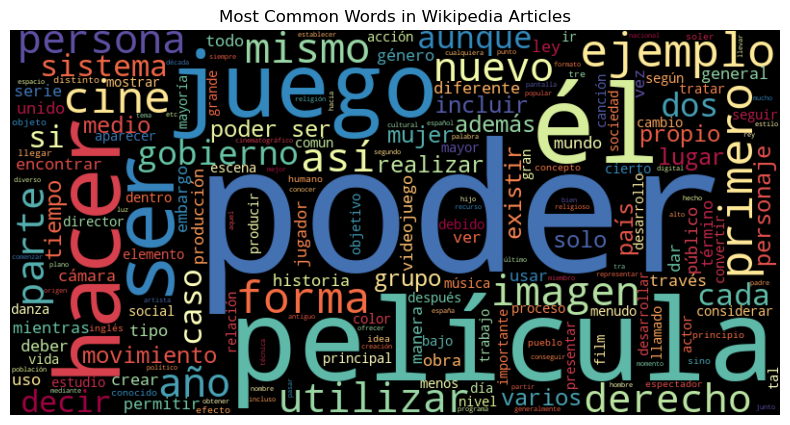

In [23]:
all_words = " ".join(data['preprocessed_extract'])
wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="Spectral").generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Wikipedia Articles")
plt.show()

del all_words

These words are much more useful for a language-learning app!

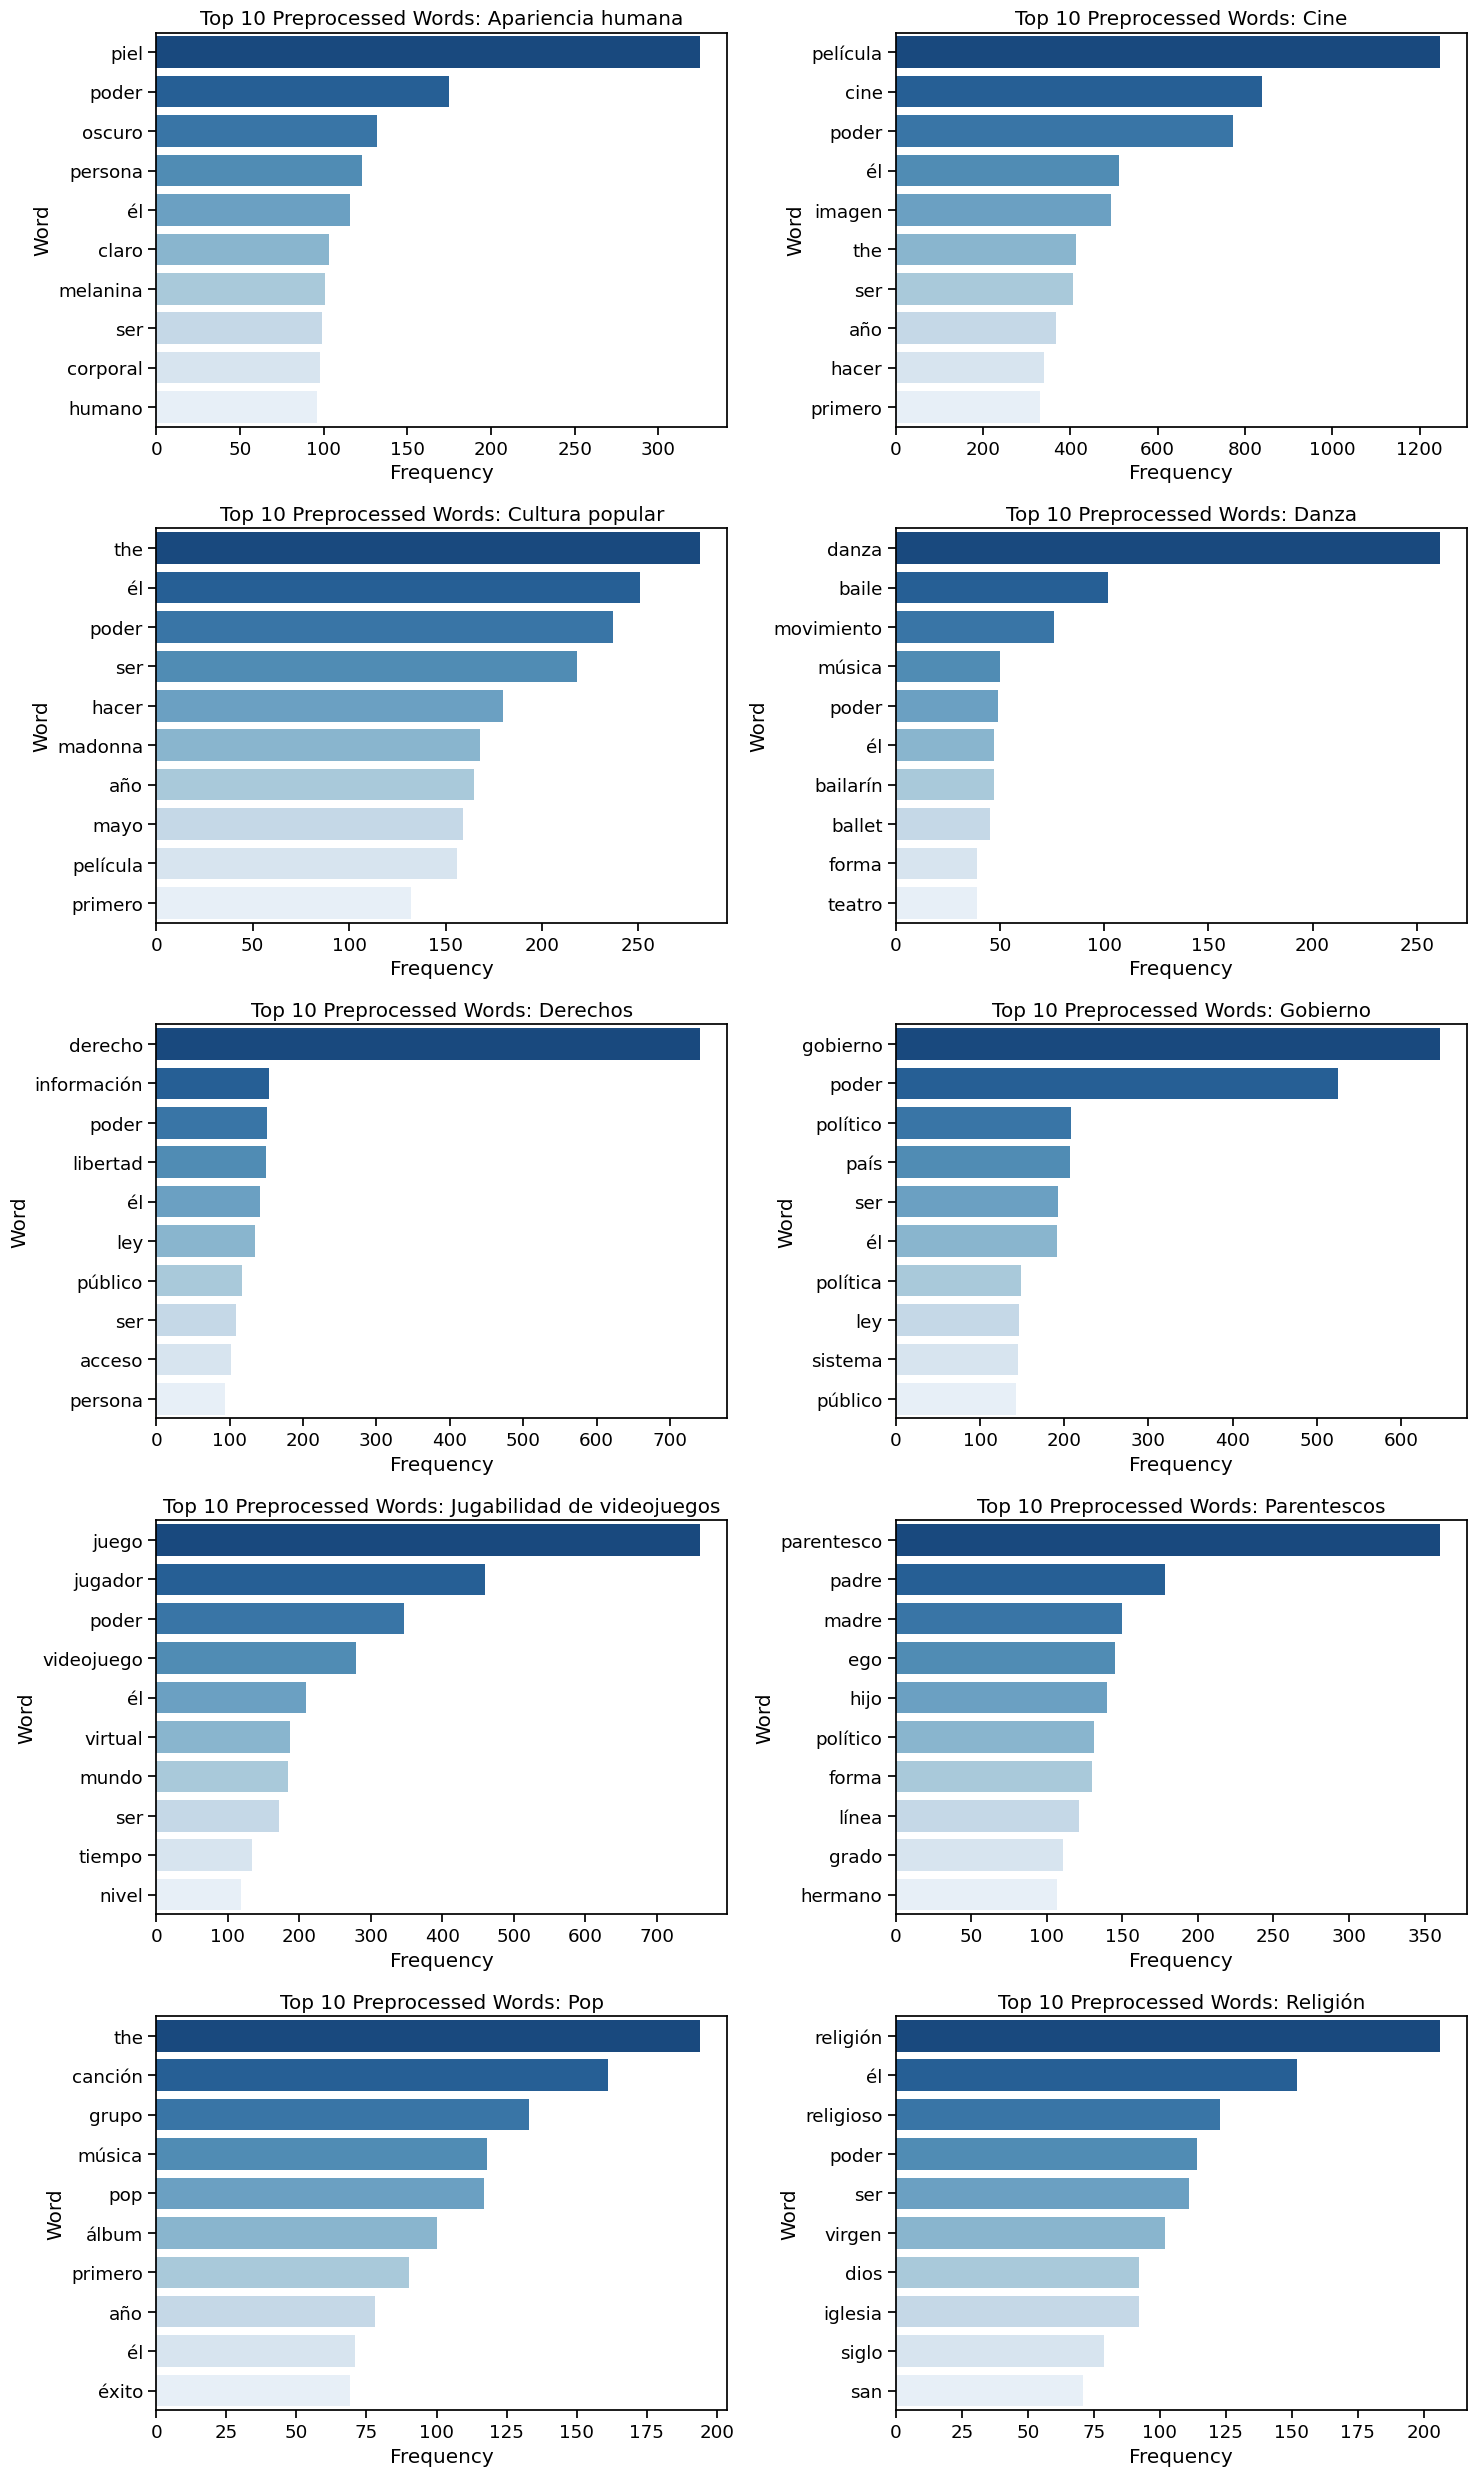

In [24]:
warnings.simplefilter("ignore")

sns.set_context("notebook", font_scale=1.2)

ncols = 2
nrows = math.ceil(len(categories) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 5))
axes = axes.flatten()

for ax, cat in zip(axes, categories):
    df_cat = data[data['category'] == cat] # Filter the dataframe for the current category
    
    # Concatenate all preprocessed_extract strings into one large string
    text = " ".join(df_cat['preprocessed_extract'].dropna().tolist())
    
    words = text.split()
    word_counts = Counter(words)
    
    top_words = word_counts.most_common(10)
    if not top_words:
        ax.set_title(f"No words for Category: {cat}")
        continue  # Skip if no words are present
    
    words_list, counts = zip(*top_words)
    
    sns.barplot(x=list(counts), y=list(words_list), palette="Blues_r", ax=ax)
    ax.set_title(f"Top 10 Preprocessed Words: {cat}")
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Word")

# Remove unused axes
for i in range(len(categories), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

The top 10 words for each category vary quite a lot, so this dataset seems to have a natural pattern for an unsupervised algorithm to pick up on. Many of the top words seem specific to their category. These groupings are so good that using the top X words for each category might accomplish my goal! 

There are fewer verbs than expected. There are only ~2 verbs per category in the top 10.

The words for "he" ("él") and "to be" ("ser) are common across almost all categories, but I would not expect them to be unique! Hopefully the model I build will separate those words out so that the list is unique to the topic.

## Unsupervised Learning

My plan is to use an unsupervised learning model to make as many clusters as categories in the data. I will tune this model and manually expect the resultant clusters. If the resultant clusters are sufficient, then I can stop there; if not, I can ensemble a supervised learning method (logistic regression) to further enhance the model. 

Because some categories are small, I don't want a randomized split of the data into train and test set because that might leave some categories with very few data points. So, I will stratify the split.

I will use non-negative matrix factorization and [Latent Dirichlet Allocation](https://www.ibm.com/think/topics/latent-dirichlet-allocation) as my unsupervised model. LDA is a Bayesian method created for topic modeling and I want to benchmark it against the NMF method learned in class.

I will use TF-IDF to create features for the model because it assigns more weight to words that are important and *discriminative*. This is a common technique in NLP to take a text dataset and make a numeric dataset for training.

### Creating the features and splitting the dataset.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    data['preprocessed_extract'],  # Features
    data['category'],
    test_size=0.2, 
    random_state=42,
    stratify=data['category']
)

print("\nTrain Set Category Distribution:")
print(y_train.value_counts())
print("\nTest Set Category Distribution:")
print(y_test.value_counts())


Train Set Category Distribution:
category
Cine                          107
Cultura popular                50
Jugabilidad de videojuegos     44
Gobierno                       42
Pop                            23
Derechos                       18
Religión                       18
Danza                          18
Parentescos                    17
Apariencia humana              15
Name: count, dtype: int64

Test Set Category Distribution:
category
Cine                          27
Cultura popular               13
Gobierno                      11
Jugabilidad de videojuegos    11
Pop                            6
Danza                          5
Derechos                       5
Religión                       4
Parentescos                    4
Apariencia humana              3
Name: count, dtype: int64


### Non-Negative Matrix Factorizaion

In [27]:
n_components = len(categories)

tfidf_vectorizer = TfidfVectorizer(max_features=100_000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train) 

nmf_model = NMF(n_components=n_components, random_state=42)
nmf_train = nmf_model.fit_transform(X_train_tfidf)

# Get the top words for each topic
# n_top_words = 10
# feature_names = tfidf_vectorizer.get_feature_names_out()

# for topic_idx, topic in enumerate(nmf_model.components_):
#     top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
#     top_words = [feature_names[i] for i in top_words_idx]
#     print(f"Topic {topic_idx}: " + " ".join(top_words))

In [28]:
tfidf_vectorizer = TfidfVectorizer(max_features=100_000)
pipeline = make_topic_pipeline(tfidf_vectorizer, nmf_model)

pipeline.fit(X_train)

topicwizard.visualize(X_train, model=pipeline)

Preprocessing
Inferring topical content for documents.


I tried assigning names of the categories to each of the clusters and I was not able to do so successfully. Some topics seemed like they would better fit totally different labels. It is hard to explain briefly my decisions for selecting the categories as each cluster has to be inspected manually but, from what I could see there were a few issues with this model:

- Some meta words were being pulled in
- The cine category seemed to be driving 4 clusters on its own! With 1 of them being clearly cine, 1 being a fusion with danza, and the remaining 2 not fitting into any topic that I could think of, let alone match to one of the categories.
- No cluster reflected 'cultura popular' or 'religion.'

For the next iteration, I will remove some of those meta labels as features and reduce the maximum number of features to 5000, was unlimited (about 33,000). And I will put a low maximum document frequency to prevent the fusions of the categories with each other, hopefully this will allow the model to find 'cultura popular' and 'religion.'

In [29]:
#2nd iteration
warnings.simplefilter("ignore")

meta_words = ['multimedio', 'wikimedia', 'categoría', 'commons', 'artículo', 'the', 'albergar', 'binding', 'songs', 'the']

def remove_custom_stop_words(text, extra_stop_words):
    words = text.split()
    filtered_words = [word for word in words if word not in extra_stop_words]
    return " ".join(filtered_words)

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000, 
    preprocessor=lambda text: remove_custom_stop_words(text, meta_words),
    max_df = .4
)

pipeline = make_topic_pipeline(tfidf_vectorizer, nmf_model)
pipeline.fit(X_train)

topicwizard.visualize(X_train, model=pipeline)

Preprocessing
Inferring topical content for documents.


This version did not perform significantly better at discovering those two categories that weren't representative of any topics. However, every topic did have a sensible topic to it. It is now clear that cine is getting split into a production and film topics; and dance is getting split into dance and festival (mixing with 'cine'). 

Here is a screenshot of the production topic:
![My Image](2_iter_production.png)

This model is not doing amazing, a top X model less stop words is close to the same performance, but without the computation. So now I will implement LDA.

### Latent Dirichlet Allocation

In [30]:
warnings.simplefilter("ignore")

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000, 
    preprocessor=lambda text: remove_custom_stop_words(text, meta_words)
)

lda_model = LatentDirichletAllocation(n_components=len(categories), random_state=42)

pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('lda', lda_model)
])

pipeline.fit(X_train)

topicwizard.visualize(X_train, model=pipeline)

Preprocessing
Inferring topical content for documents.


This model performed VERY significantly worse than NMF. The topics seem much more confused within themselves. Meaning, I myself am unable to find a topic to describe what could be the overarching topic in that cluster --let alone match it to one of the categories.

At this point, I am beginning to believe that unsupervised learning cannot find the underlying 10 topics. As a last hurrah, I will reduce the categories to 8 to see if it will perfectly categorize 8 clusters --expecting it to leave out 'religion' and 'culture popular.'

In [31]:
warnings.simplefilter("ignore")

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000, 
    preprocessor=lambda text: remove_custom_stop_words(text, meta_words),
    min_df=.01, max_df=.2
)

lda_model = LatentDirichletAllocation(n_components=len(categories)-2, random_state=42)

pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('lda', lda_model)
])

pipeline.fit(X_train)

topicwizard.visualize(X_train, model=pipeline)

Preprocessing
Inferring topical content for documents.


Again, communicating the results is very different since it requires manual inspection, but again LDA performed significantly worse than NMF, with topics not being very apparent within the clusters.

I made many models varying the document frequency --both the minimum and maximum-- and LDA consistently did not perform well. I was very confused by this result. Perhaps it is due to excessive co-occurences between words as there were many shared words in the topics. Or, perhaps it is because

NMF produced decent results but arguably not anything better than just the top X preprocessed words by frequency. However, this dataset has labels that can be used. So supervised or guided learning methods can be used instead.

## Supervised Learning

I will be using a classic Logistic Regression in combination with an NMF TF-IDF model.

### Categorized TF-IDF

In [32]:
class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """
        Learn the idf vector (global term weights)
        """
        _, n_features = X.shape
        # Use the sum across classes as document frequency
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """
        Transform a count-based matrix to c-TF-IDF 
        """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X


# Create documents per label
docs = pd.DataFrame({'Document': X_train, 'category': y_train})
docs_per_class = docs.groupby('category', as_index=False).agg({'Document': ' '.join})

# Create c-TF-IDF
count_vectorizer = CountVectorizer().fit(docs_per_class.Document)
count = count_vectorizer.transform(docs_per_class.Document)
words = count_vectorizer.get_feature_names_out()  # Newer method instead of get_feature_names()

# Compute the class-based TF-IDF:
# Pass total number of original documents as n_samples.
ctfidf_matrix = CTFIDFVectorizer().fit_transform(count, n_samples=len(docs)).toarray()

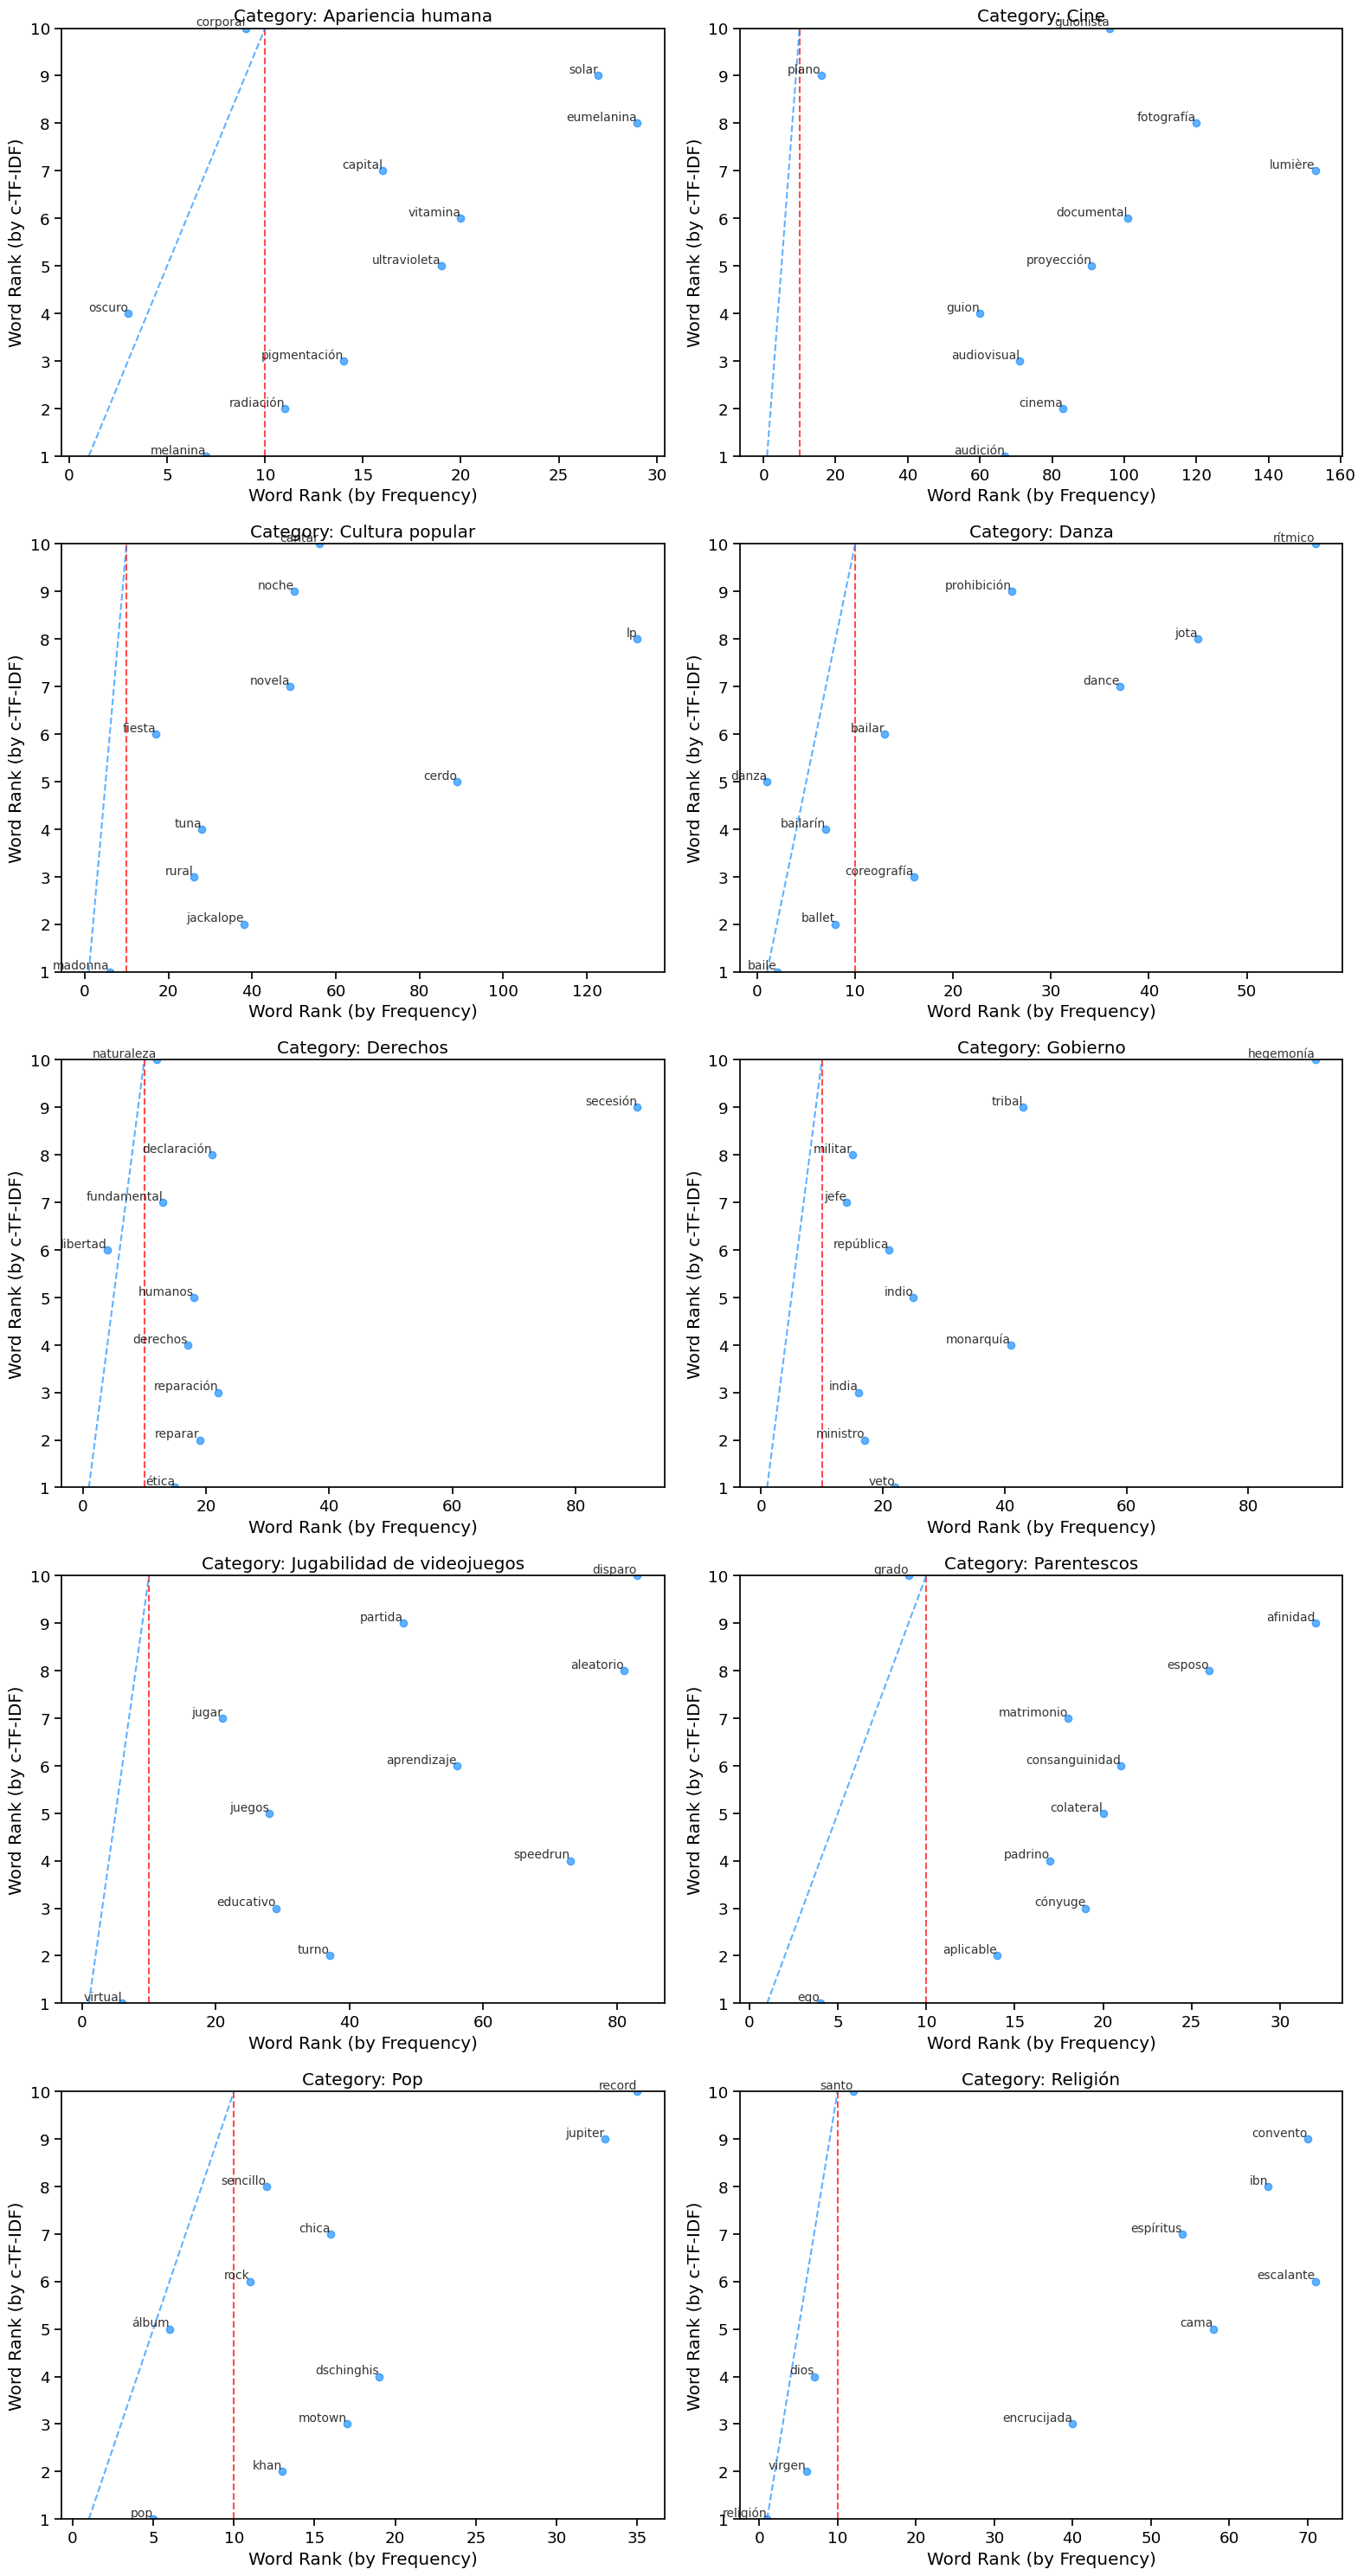

In [33]:
# Comparing category frequency rank to the c-TF-IDF rank

# Extract the top 10 words per class by c-TF-IDF score.
ctfidf_words = {}
for i, cat in enumerate(docs_per_class['category']):
    row = ctfidf_matrix[i]
    top_indices = row.argsort()[-10:][::-1]  # indices of top 10 words
    top_words = [(words[index], row[index]) for index in top_indices]
    ctfidf_words[cat] = top_words



# Grid layout for subplots
n_categories = len(categories)
ncols = 2 
nrows = math.ceil(n_categories / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 6))
axes = axes.flatten()

for ax, cat in zip(axes, categories):
    # Word Frequency
    df_cat = data[data['category'] == cat]
    text = " ".join(df_cat['preprocessed_extract'].dropna().tolist())
    word_list = text.split()
    word_counts = Counter(word_list)
    
    # Get word ranks by frequency
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    word_ranks = {word: rank + 1 for rank, (word, _) in enumerate(sorted_words)}
    
    # c-TF-IDF Scores
    top_ctfidf_list = ctfidf_words.get(cat, [])
    sorted_ctfidf = sorted(top_ctfidf_list, key=lambda x: x[1], reverse=True)
    ctfidf_ranks = {word: rank + 1 for rank, (word, _) in enumerate(sorted_ctfidf)}
    
    # Get Words to Plot
    common_words = set(word_ranks.keys()).intersection(set(ctfidf_ranks.keys()))
    x_vals = [word_ranks[w] for w in common_words]
    y_vals = [ctfidf_ranks[w] for w in common_words]


    
    # Scatter plot
    point_color = "dodgerblue"
    ax.scatter(x_vals, y_vals, color=point_color, alpha=0.7)
    
    # Labels
    for w, x, y in zip(common_words, x_vals, y_vals):
        ax.text(x, y, w, fontsize=10, ha='right', va='bottom', alpha=0.8)

    # Guiding lines
    ax.axvline(x=10, color="red", linestyle="--", alpha=0.7)
    max_rank = max(max(x_vals, default=0), max(y_vals, default=0))
    ax.plot([1, max_rank], [1, max_rank], color=point_color, linestyle="--", alpha=0.7)

    ax.set_ylim(1, 10)
    
    ax.set_title(f"Category: {cat}")
    ax.set_xlabel("Word Rank (by Frequency)")
    ax.set_ylabel("Word Rank (by c-TF-IDF)")
    
for j in range(n_categories, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

This plot maps the rankings of the top 10 words by c-TF-IDF against its word rank by frequency. Remember: creating more useful vocabulary sets than a top X model (preprocessed for stop words and lemmatized) is the goal of this model. 

If c-TF-IDF ranked matches exactly, then the output would be a perfect y=x line. This is not the case. I added a vertical line to show when top 10 words by c-TF-IDF are outside of the top 10 words by frequency for their category. I also included the y=x line. 

While most categories do have a positive slope like a perfect y=x, they do not match fairly well. This is not a large surprise, after all, count frequency is only part of the c-TF-IDF formula for a reason. However, it does give an idea of how different the two metrics will output a vocabulary set. 'Jugabilidad de videojuegos' is a particularly good example of this disparity.

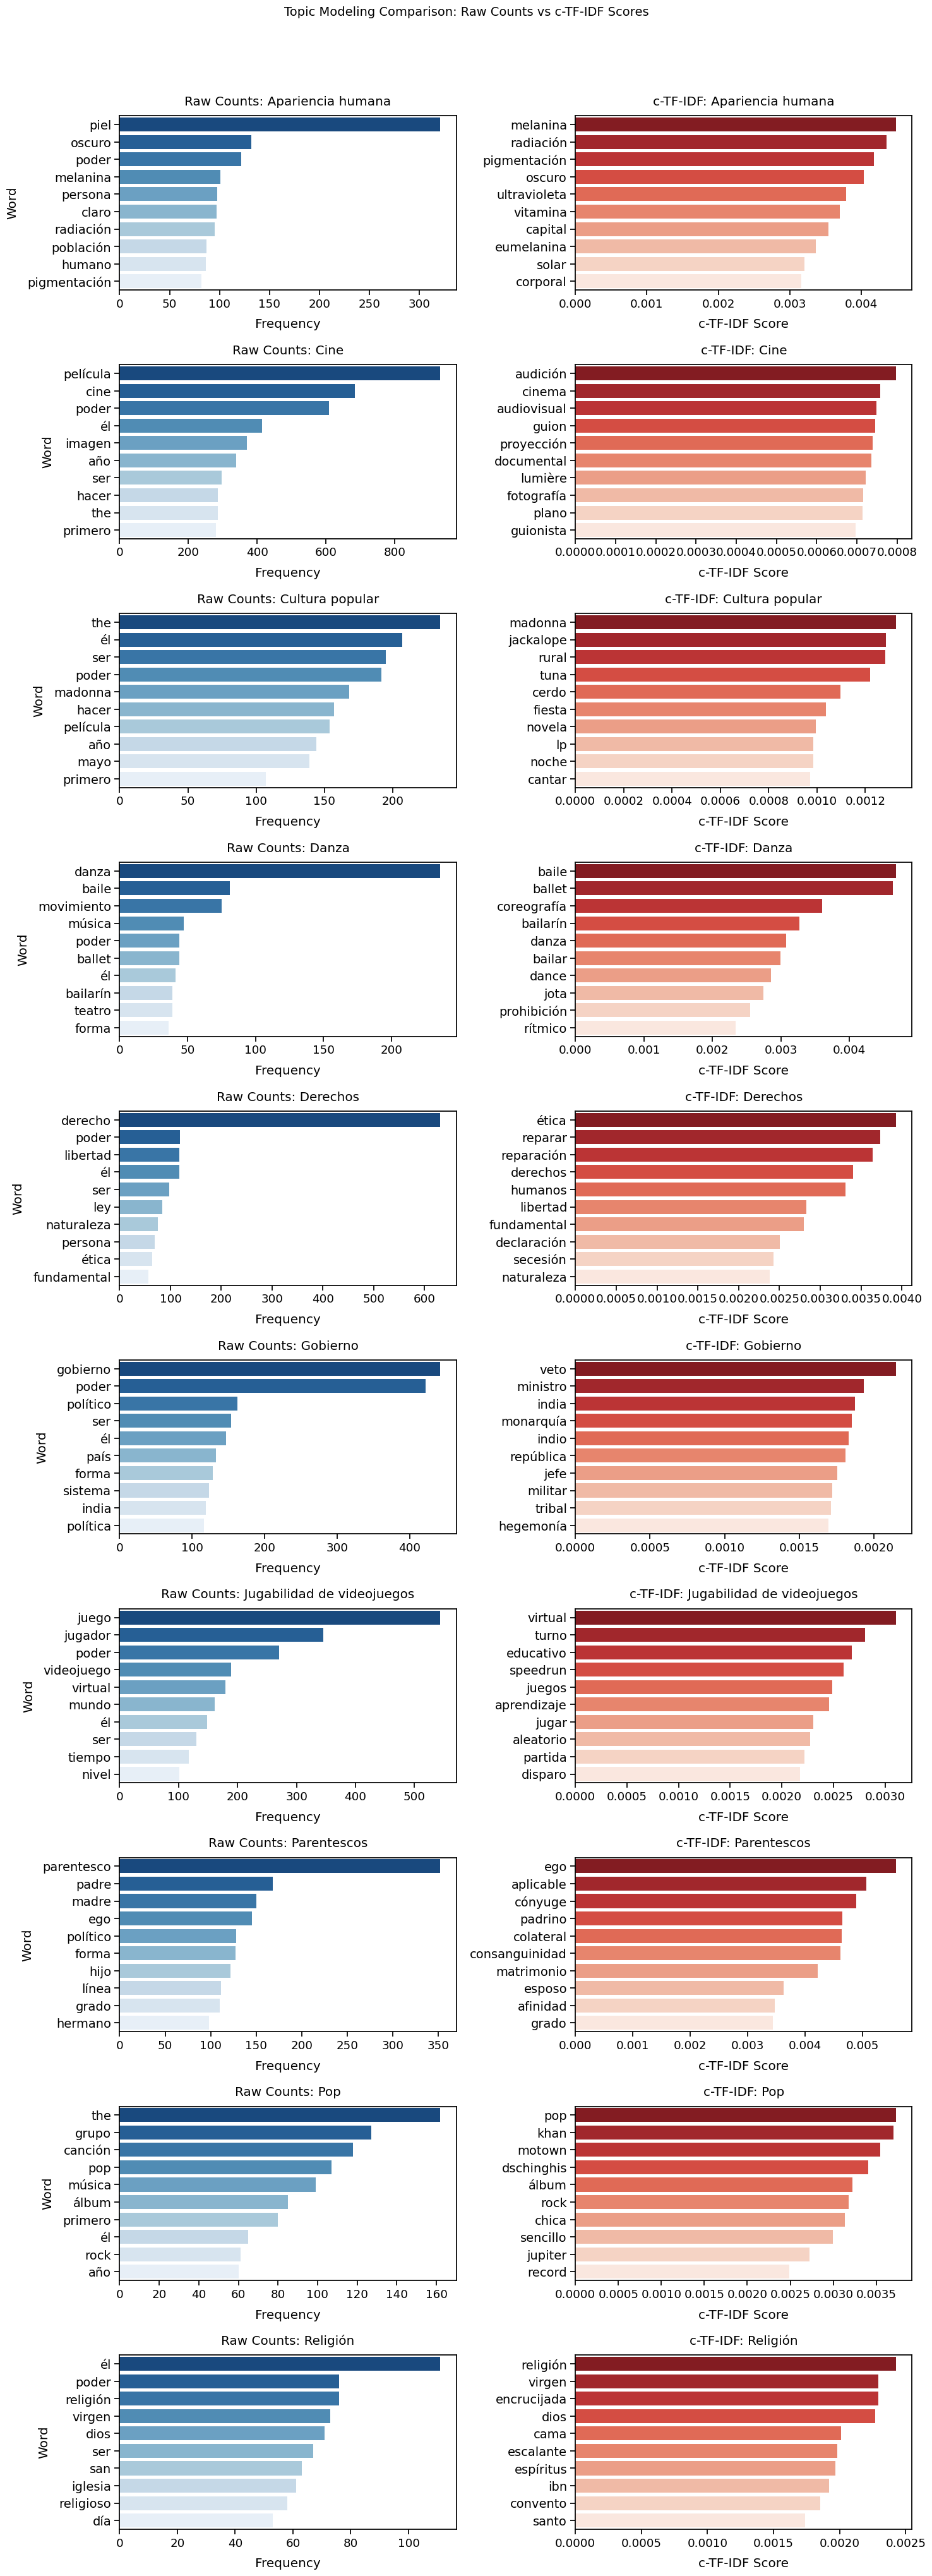

In [34]:
# Comparing category frequency plots to c-TF-IDF plots

# Hide deprecation warnings
warnings.simplefilter("ignore", category=FutureWarning)

# Extract the top 10 words per class by c-TF-IDF score.
ctfidf_words = {}
for i, cat in enumerate(docs_per_class['category']):
    row = ctfidf_matrix[i]
    top_indices = row.argsort()[-10:][::-1]  # indices of top 10 words
    top_words = [(words[index], row[index]) for index in top_indices]
    ctfidf_words[cat] = top_words


best_params = {'top_n_words': 10}

# Visualization
nrows = len(docs_per_class['category'])
ncols = 2  # Only 2 columns now
fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 4))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
axes = axes.flatten()

for i, cat in enumerate(docs_per_class['category']):
    # Left plot: Raw counts per category (Blue)
    ax_raw = axes[i * 2]
    df_cat = docs[docs['category'] == cat]
    text = " ".join(df_cat['Document'].dropna().tolist())
    words_list = text.split()
    word_counts = Counter(words_list)
    top_raw = word_counts.most_common(best_params['top_n_words'])
    
    if top_raw:
        raw_words, raw_counts = zip(*top_raw)
        sns.barplot(x=list(raw_counts), y=list(raw_words), palette="Blues_r", ax=ax_raw)
        ax_raw.set_title(f"Raw Counts: {cat}", pad=12)
        ax_raw.set_xlabel("Frequency", labelpad=10)
        ax_raw.set_ylabel("Word", labelpad=10)
        ax_raw.tick_params(axis='y', labelsize=14)
    else:
        ax_raw.set_title(f"No words for: {cat}")
        ax_raw.axis('off')

    # Right plot: c-TF-IDF scores (Red)
    ax_ctfidf = axes[i * 2 + 1]
    top_ctfidf = ctfidf_words.get(cat, [])
    
    if top_ctfidf:
        ctfidf_words_list, scores = zip(*top_ctfidf)
        sns.barplot(x=list(scores), y=list(ctfidf_words_list), palette="Reds_r", ax=ax_ctfidf)
        ax_ctfidf.set_title(f"c-TF-IDF: {cat}", pad=12)
        ax_ctfidf.set_xlabel("c-TF-IDF Score", labelpad=10)
        ax_ctfidf.set_ylabel("")
        ax_ctfidf.tick_params(axis='y', labelsize=14)
    else:
        ax_ctfidf.set_title(f"No words for: {cat}")
        ax_ctfidf.axis('off')

# Remove empty subplots if any
for j in range(nrows * ncols, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(
    "Topic Modeling Comparison: Raw Counts vs c-TF-IDF Scores",
    y=1.02,
    fontsize=14
)

plt.tight_layout()
plt.show()

This set of visualizations lets me manually compare the top 10 words by the c-TF-IDF and frequency scores. In order to see which performs better, I will mark which performed better for each category to see if I have improved upon a top X preprocessed words model.

🔵 = Top X preprocessed words by frequency was the best model
<br>🔴 = Top X c-TF-IDF was the best model
<br> *More than one circle means it's a tie for best model*
- Apariencia humana:🔴 
- Cine: 🔴
- Cultura popular: 🔴
- Danza: 🔴
- Derechos: 🔴
- Gobierno: 🔵
- Jugabilidad de videojuegos: 🔵🔴
- Parentescos: 🔴
- Pop: 🔵🔴 (both were poor)
- Religión: 🔵

So, the c-TF-IDF did perform better than the top X preprocessed words model. Let's see what happens if I use c-TF-IDF in my model.

### NMF

In [35]:
# Cleaner version than above cell
class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log((n_samples + 1) / (df + 1)) + 1
        self._idf_diag = sp.diags(idf, offsets=0,
                                shape=(n_features, n_features),
                                format='csr',
                                dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        X[X < 0] = 0
        return X

# Prepare to store results
results = []

# Create documents per label
train_df = pd.DataFrame({'Document': X_train, 'category': y_train})
docs_per_class = train_df.groupby('category', as_index=False).agg({'Document': ' '.join})

# Parameter grids
max_dfs = [.21, .5,.7,.9]
min_dfs = [0.01, 0.05, 0.1, 0.2]
max_features = [1000, 5000, 10000]
for maxdf in max_dfs:
    for mindf in min_dfs:
        for mf in max_features: 
            try:
                # Create count vectors
                count_vectorizer = CountVectorizer(min_df=mindf, max_features=mf, max_df=maxdf).fit(docs_per_class['Document'])
                class_counts = count_vectorizer.transform(docs_per_class['Document'])
                
                # Skip if any class has no words
                if class_counts.sum(axis=1).min() == 0:
                    results.append({
                        'min_df': mindf,
                        'max_df': maxdf,
                        'max_features': mf,
                        'accuracy': np.nan,
                        'status': 'Skipped (empty class)'
                    })
                    continue
                
                # Compute c-TF-IDF
                ctfidf_vectorizer = CTFIDFVectorizer()
                ctfidf_vectorizer.fit(class_counts, n_samples=len(X_train))
                ctfidf = ctfidf_vectorizer.transform(class_counts).toarray()
                
                # NMF
                n_topics = len(docs_per_class)
                nmf = NMF(n_components=n_topics, random_state=42)
                W_class = nmf.fit_transform(ctfidf)
                
                # Test predictions
                test_counts = count_vectorizer.transform(X_test)
                test_ctfidf = ctfidf_vectorizer.transform(test_counts).toarray()
                W_test = nmf.transform(test_ctfidf)
                
                similarities = cosine_similarity(W_test, W_class)
                predictions = np.argmax(similarities, axis=1)
                predicted_labels = docs_per_class['category'].values[predictions]
                
                accuracy = np.mean(predicted_labels == y_test)
                
                # Store results
                results.append({
                    'min_df': mindf,
                    'max_df': maxdf,
                    'max_features': mf,
                    'accuracy': accuracy,
                    'status': 'Success'
                })
                
            except Exception as e:
                results.append({
                    'min_df': mindf,
                    'max_df': maxdf,
                    'max_features': mf,
                    'accuracy': np.nan,
                    'status': f'Failed: {str(e)}'
                })

results_df = pd.DataFrame(results)

results_df['accuracy_pct'] = results_df['accuracy'].apply(
    lambda x: f"{x:.2%}" if not pd.isna(x) else 'N/A'
)

final_results = results_df\
    .sort_values(['accuracy', 'max_features'], ascending=[False, True])\
    .reset_index(drop=True)

print("\n=== Parameter Tuning Results Ordered by Accuracy ===")
print(final_results.head(10))


=== Parameter Tuning Results Ordered by Accuracy ===
   min_df  max_df  max_features  accuracy   status accuracy_pct
0    0.01     0.9          5000  0.853933  Success       85.39%
1    0.05     0.9          5000  0.853933  Success       85.39%
2    0.10     0.9          5000  0.853933  Success       85.39%
3    0.01     0.7         10000  0.853933  Success       85.39%
4    0.05     0.7         10000  0.853933  Success       85.39%
5    0.10     0.7         10000  0.853933  Success       85.39%
6    0.01     0.7          5000  0.842697  Success       84.27%
7    0.05     0.7          5000  0.842697  Success       84.27%
8    0.10     0.7          5000  0.842697  Success       84.27%
9    0.20     0.7          5000  0.842697  Success       84.27%


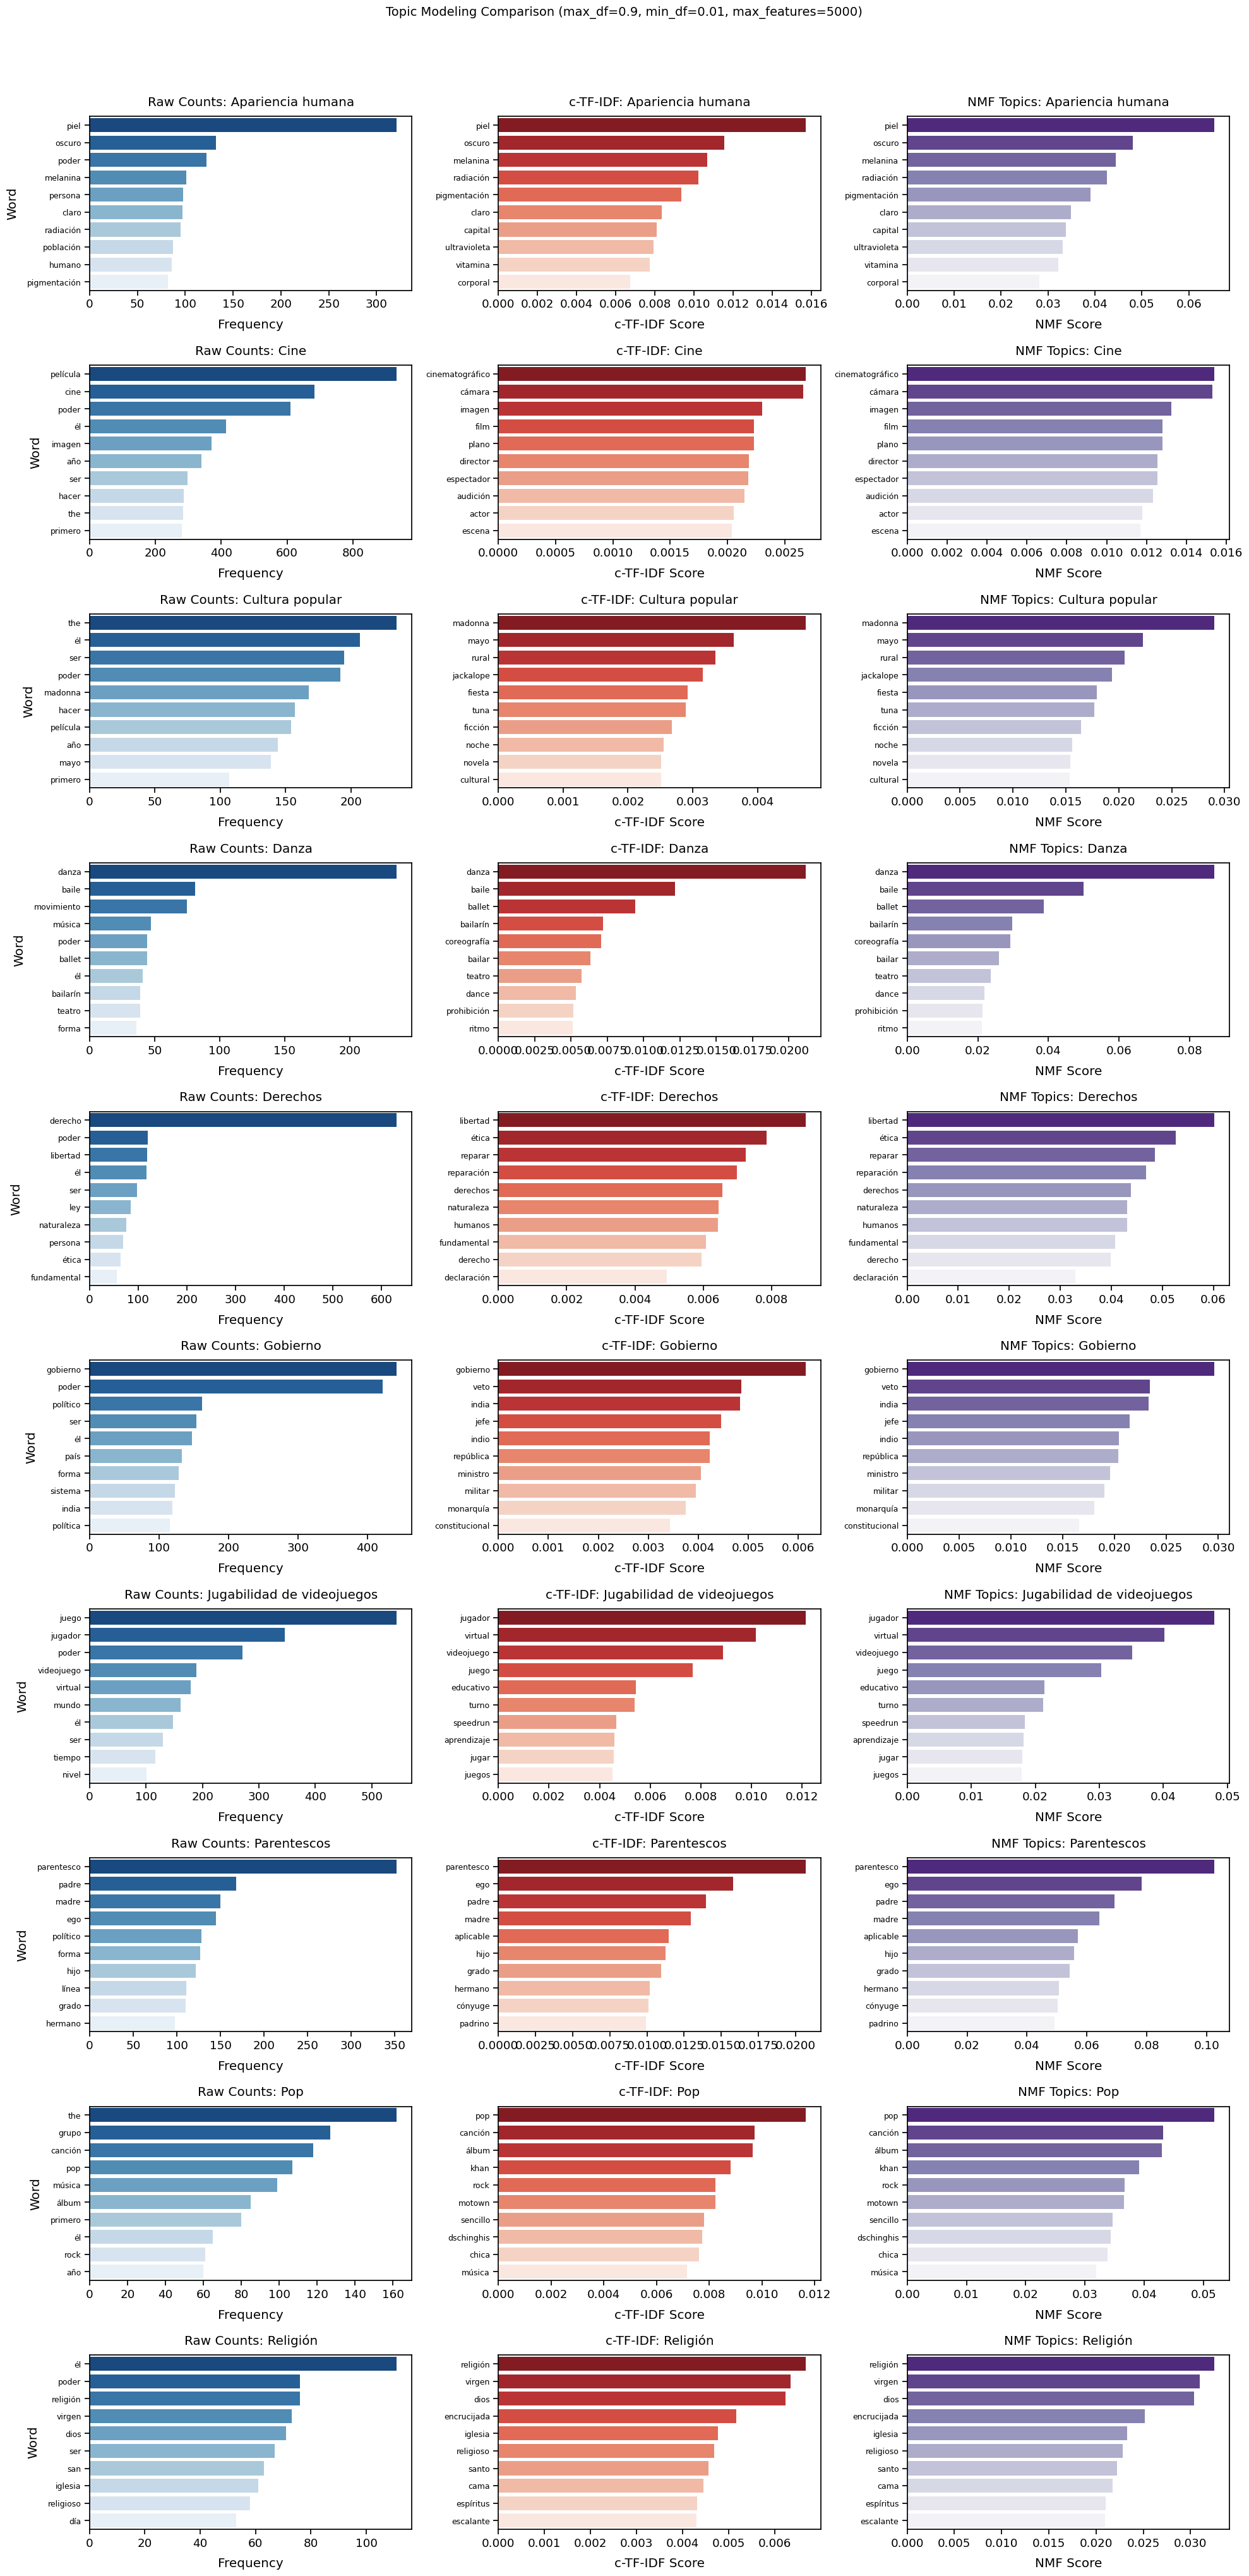

In [36]:
warnings.simplefilter("ignore", category=FutureWarning)

best_params = {
    'max_df': 0.9,
    'min_df': 0.01,
    'max_features': 5000,
    'top_n_words': 10
}

docs = pd.DataFrame({'Document': X_train, 'category': y_train})
docs_per_class = docs.groupby('category', as_index=False).agg({'Document': ' '.join})

count_vectorizer = CountVectorizer(
    max_df=best_params['max_df'],
    min_df=best_params['min_df'],
    max_features=best_params['max_features']
).fit(docs_per_class['Document'])
count = count_vectorizer.transform(docs_per_class['Document'])
words = count_vectorizer.get_feature_names_out()

# Compute c-TF-IDF
ctfidf_matrix = CTFIDFVectorizer().fit_transform(count, n_samples=len(docs)).toarray()

n_topics = len(docs_per_class)
nmf = NMF(n_components=n_topics, random_state=42)
W_class = nmf.fit_transform(ctfidf_matrix)
H_class = nmf.components_


# Compute similarity between original c-TF-IDF vectors and NMF components
similarity = cosine_similarity(ctfidf_matrix, H_class)
topic_to_category = similarity.argmax(axis=1)  # Which topic best represents each category

# Reorganize NMF words based on best matches
nmf_words = {}
for cat_idx, cat in enumerate(docs_per_class['category']):
    topic_idx = topic_to_category[cat_idx]
    row = H_class[topic_idx]
    top_indices = row.argsort()[-best_params['top_n_words']:][::-1]
    top_words = [(words[idx], row[idx]) for idx in top_indices]
    nmf_words[cat] = top_words

# Extract top words for c-TF-IDF
ctfidf_words = {}
for i, cat in enumerate(docs_per_class['category']):
    row = ctfidf_matrix[i]
    top_indices = row.argsort()[-best_params['top_n_words']:][::-1]
    top_words = [(words[idx], row[idx]) for idx in top_indices]
    ctfidf_words[cat] = top_words










# ====================== VISUALIZATION ======================
nrows = len(docs_per_class['category'])
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 4))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
axes = axes.flatten()

for i, cat in enumerate(docs_per_class['category']):
    # Left plot: Raw counts per category
    ax_raw = axes[i * 3]
    df_cat = docs[docs['category'] == cat]
    text = " ".join(df_cat['Document'].dropna().tolist())
    words_list = text.split()
    word_counts = Counter(words_list)
    top_raw = word_counts.most_common(best_params['top_n_words'])
    
    if top_raw:
        raw_words, raw_counts = zip(*top_raw)
        sns.barplot(x=list(raw_counts), y=list(raw_words), palette="Blues_r", ax=ax_raw)
        ax_raw.set_title(f"Raw Counts: {cat}", pad=12)
        ax_raw.set_xlabel("Frequency", labelpad=10)
        ax_raw.set_ylabel("Word", labelpad=10)
        ax_raw.tick_params(axis='y', labelsize=9)
    else:
        ax_raw.set_title(f"No words for: {cat}")
        ax_raw.axis('off')


    # Middle plot: c-TF-IDF scores
    ax_ctfidf = axes[i * 3 + 1]
    top_ctfidf = ctfidf_words.get(cat, [])
    
    if top_ctfidf:
        ctfidf_words_list, scores = zip(*top_ctfidf)
        sns.barplot(x=list(scores), y=list(ctfidf_words_list), palette="Reds_r", ax=ax_ctfidf)
        ax_ctfidf.set_title(f"c-TF-IDF: {cat}", pad=12)
        ax_ctfidf.set_xlabel("c-TF-IDF Score", labelpad=10)
        ax_ctfidf.set_ylabel("")
        ax_ctfidf.tick_params(axis='y', labelsize=9)
    else:
        ax_ctfidf.set_title(f"No words for: {cat}")
        ax_ctfidf.axis('off')

    
    # Right plot: NMF top words
    ax_nmf = axes[i * 3 + 2]
    top_nmf = nmf_words.get(cat, [])
    
    if top_nmf:
        nmf_words_list, nmf_scores = zip(*top_nmf)
        sns.barplot(x=list(nmf_scores), y=list(nmf_words_list), palette="Purples_r", ax=ax_nmf)
        ax_nmf.set_title(f"NMF Topics: {cat}", pad=12)
        ax_nmf.set_xlabel("NMF Score", labelpad=10)
        ax_nmf.set_ylabel("")
        ax_nmf.tick_params(axis='y', labelsize=9)
    else:
        ax_nmf.set_title(f"No words for: {cat}")
        ax_nmf.axis('off')

# Remove empty subplots
for j in range(nrows * ncols, len(axes)):
    fig.delaxes(axes[j])


plt.suptitle(
    f"Topic Modeling Comparison (max_df={best_params['max_df']}, " +
    f"min_df={best_params['min_df']}, " +
    f"max_features={best_params['max_features']})",
    y=1.02,
    fontsize=14
)

plt.tight_layout()
plt.show()

NMF gives *exactly* the same results as c-TF-IDF. It would seem that training an NMF on one categoy's TF-IDF leads NMF to give the exact weights to those words. However, NMF, along with cosign similarity, allows for the prediction of new data --which is useful for model validation.

So, the best model that I am able to make is this one. And, for my purposes, I can just create word lists using the top X c-TF-IDF without having to fit an NMF.

### Logistic Regression + TF-IDF

In [37]:
import pandas as pd
import warnings
warnings.simplefilter("ignore")

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(max_iter=1000))
])

param_grid = {
    'tfidf__max_features': [500, 1000, 2500, 5000], 
    'logreg__C': [0.1, 1, 10, 100, 1000, 10000], 
    'logreg__solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(grid_search.cv_results_)

results_df = results_df[['params', 'mean_test_score']]
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

pd.set_option('display.max_colwidth', None) 
results_df.head(10)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


,params,mean_test_score
41,"{'logreg__C': 10000, 'logreg__solver': 'liblinear', 'tfidf__max_features': 1000}",0.874885
46,"{'logreg__C': 10000, 'logreg__solver': 'lbfgs', 'tfidf__max_features': 2500}",0.869260
42,"{'logreg__C': 10000, 'logreg__solver': 'liblinear', 'tfidf__max_features': 2500}",0.869236
45,"{'logreg__C': 10000, 'logreg__solver': 'lbfgs', 'tfidf__max_features': 1000}",0.866411
43,"{'logreg__C': 10000, 'logreg__solver': 'liblinear', 'tfidf__max_features': 5000}",0.866411
34,"{'logreg__C': 1000, 'logreg__solver': 'liblinear', 'tfidf__max_features': 2500}",0.866387
33,"{'logreg__C': 1000, 'logreg__solver': 'liblinear', 'tfidf__max_features': 1000}",0.863538
38,"{'logreg__C': 1000, 'logreg__solver': 'lbfgs', 'tfidf__max_features': 2500}",0.860713
37,"{'logreg__C': 1000, 'logreg__solver': 'lbfgs', 'tfidf__max_features': 1000}",0.860713
26,"{'logreg__C': 100, 'logreg__solver': 'liblinear', 'tfidf__max_features': 2500}",0.857888


The solver seemed to make no difference. A higher C seems preferable but that could just be the model overfitting. So I will prefer C=1000 which is slightly more regularized than the 10,0000 and only comes at the cost of 1% accuracy. Max features of 1000 and 25000 performed best. I will use 1000 since it is more computationally efficient.

In [38]:
warnings.simplefilter("ignore", category=FutureWarning)

# c-TF-IDF
best_params = {
    'max_df': 0.9,
    'min_df': 0.01,
    'max_features': 1000,
    'top_n_words': 10
}

docs = pd.DataFrame({'Document': X_train, 'category': y_train})
docs_per_class = docs.groupby('category', as_index=False).agg({'Document': ' '.join})

count_vectorizer = CountVectorizer(
    max_df=best_params['max_df'],
    min_df=best_params['min_df'],
    max_features=best_params['max_features']
).fit(docs_per_class['Document'])
count = count_vectorizer.transform(docs_per_class['Document'])
words = count_vectorizer.get_feature_names_out()

ctfidf_matrix = CTFIDFVectorizer().fit_transform(count, n_samples=len(docs)).toarray()

# Extract top words for c-TF-IDF
ctfidf_words = {}
for i, cat in enumerate(docs_per_class['category']):
    row = ctfidf_matrix[i]
    top_indices = row.argsort()[-best_params['top_n_words']:][::-1]
    top_words = [(words[idx], row[idx]) for idx in top_indices]
    ctfidf_words[cat] = top_words


# LogReg
# Set parameters manually for the final model
best_params = {
    'max_df': 0.9,        
    'min_df': 0.01,       
    'max_features': 1000, 
    'top_n_words': 10,    
    'C': 1000,            
    'solver': 'liblinear' 

# Prepare the documents and their categories
docs = pd.DataFrame({'Document': X_train, 'category': y_train})
docs_per_class = docs.groupby('category', as_index=False).agg({'Document': ' '.join})

vectorizer = TfidfVectorizer(
    max_df=best_params['max_df'],
    min_df=best_params['min_df'],
    max_features=best_params['max_features']
)

logreg_model = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    max_iter=1000
)

# Transform the documents using the vectorizer
X_tfidf = vectorizer.fit_transform(docs_per_class['Document'])

logreg_model.fit(X_tfidf, docs_per_class['category'])
feature_names = vectorizer.get_feature_names_out()
class_labels = logreg_model.classes_
logreg_words = {}
for i, class_label in enumerate(class_labels):
    # Get the top N words for the class
    top_idx = np.argsort(logreg_model.coef_[i])[-best_params['top_n_words']:][::-1]
    top_words = [(feature_names[idx], logreg_model.coef_[i][idx]) for idx in top_idx]
    logreg_words[class_label] = top_words






# ====================== VISUALIZATION ======================
nrows = len(docs_per_class['category'])
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 4))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
axes = axes.flatten()

for i, cat in enumerate(docs_per_class['category']):
    # Left plot: Raw counts per category
    ax_raw = axes[i * 3]
    df_cat = docs[docs['category'] == cat]
    text = " ".join(df_cat['Document'].dropna().tolist())
    words_list = text.split()
    word_counts = Counter(words_list)
    top_raw = word_counts.most_common(best_params['top_n_words'])
    
    if top_raw:
        raw_words, raw_counts = zip(*top_raw)
        sns.barplot(x=list(raw_counts), y=list(raw_words), palette="Blues_r", ax=ax_raw)
        ax_raw.set_title(f"Raw Counts: {cat}", pad=12)
        ax_raw.set_xlabel("Frequency", labelpad=10)
        ax_raw.set_ylabel("Word", labelpad=10)
        ax_raw.tick_params(axis='y', labelsize=9)
    else:
        ax_raw.set_title(f"No words for: {cat}")
        ax_raw.axis('off')


    # Middle plot: c-TF-IDF scores
    ax_ctfidf = axes[i * 3 + 1]
    top_ctfidf = ctfidf_words.get(cat, [])
    
    if top_ctfidf:
        ctfidf_words_list, scores = zip(*top_ctfidf)
        sns.barplot(x=list(scores), y=list(ctfidf_words_list), palette="Reds_r", ax=ax_ctfidf)
        ax_ctfidf.set_title(f"c-TF-IDF: {cat}", pad=12)
        ax_ctfidf.set_xlabel("c-TF-IDF Score", labelpad=10)
        ax_ctfidf.set_ylabel("")
        ax_ctfidf.tick_params(axis='y', labelsize=9)
    else:
        ax_ctfidf.set_title(f"No words for: {cat}")
        ax_ctfidf.axis('off')

    
    # Right plot: Logistic Regression top words
    ax_logreg = axes[i * 3 + 2]
    top_logreg = logreg_words.get(cat, [])
    
    if top_logreg:
        logreg_words_list, scores = zip(*top_logreg)
        sns.barplot(x=list(scores), y=list(logreg_words_list), palette="Greens_r", ax=ax_logreg)
        ax_logreg.set_title(f"LogReg Top Words: {cat}", pad=12)
        ax_logreg.set_xlabel("LogReg Coefficients", labelpad=10)
        ax_logreg.set_ylabel("")
        ax_logreg.tick_params(axis='y', labelsize=9)
    else:
        ax_logreg.set_title(f"No words for: {cat}")
        ax_logreg.axis('off')

# Remove empty subplots
for j in range(nrows * ncols, len(axes)):
    fig.delaxes(axes[j])


plt.suptitle(
    f"Topic Modeling Comparison Raw Counts vs c-TF-IDF (best model) vs LogReg Model",
    y=1.02,
    fontsize=14
)

plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (1460009599.py, line 44)

LogReg + TF-IDF produces results very very similar to but not equal to c-TF-IDF

🔵 = Top X preprocessed words by frequency was the best model
<br>🔴 = Top X c-TF-IDF was the best model
<br>🟢 = LogReg + TF-IDF was the best model
<br> *More than one circle means it's a tie for best model*
- Apariencia humana: 🟢
- Cine: 🔴🟢
- Cultura popular: 🔴
- Danza: 🔴🟢
- Derechos: 🔴🟢
- Gobierno: 🔵🔴🟢
- Jugabilidad de videojuegos: 🟢
- Parentescos: 🔵🟢
- Pop: 🔵 (all were poor on this category)
- Religión: 🔴

<br>
<br>
For comparison: Prior results (no Log Reg)

- Apariencia humana:🔴 
- Cine: 🔴
- Cultura popular: 🔴
- Danza: 🔴
- Derechos: 🔴
- Gobierno: 🔵
- Jugabilidad de videojuegos: 🔵🔴
- Parentescos: 🔴
- Pop: 🔵🔴 (both were poor)
- Religión: 🔵
<br>
<br>
The LogReg model did perform even better than the top X c-TF-IDF model. While this result isn't surprising, it is admirable how well a top X preprocessed words model performs given how simple it is! 

## Conclusion

### Initial Conclusion

Supervised learning models outperformed the unsupervised learning models by a slight margin and both outperformed the top X preprocessed words by frequency model. Labeled data is very powerful so it is generally expected to outperform unsupervised methods. However, the unsupervised methods did find some patterns in the data. I imagine that with more data, the unsupervised topic modeling would have performed much better. I also wonder if the class imbalance was driving too much of a difference given the smaller training samples for the smaller categories. Also, this is not shown in this notebook but I had tried using the soccer and football categories in training and the unsupervised models greatly struggled to separate video games from the two sports. I also am skeptical that a purely unsupervised approach would have done much better at separating the three even with more data. Thankfully, getting labeled data for a use case such as this is easy so exclusively using unsupervised models is not necessary. One other possible improvement would be placing more weight on the see more and the categories sections of the Wikipedia articles as these are highly informative.

**The biggest takeaway that I have from this project is the power of raw counts.** While it was the worst performing --aside from LDA, though perhaps LDA could have been tuned to get to the same level-- it still performed respectably. I belive the real power of a this raw data model is in just how easy it is to make. It just required preprocessing the data. And, with it quickly able to output X words for a category, a human can manually inspect those words and remove words accordingly. This is quick for a human to do. A human can easily see that "Él" ("he) is not a very useful word for a vocabulary deck and remove it. Additionally, sometimes you want words that are shared between categories to study. For example, the word "jugar" ("to play") is a word that I would want in a vocab deck for all three categories: video games, soccer, and American football. Therefore, **from a business standpoint, my recommendation would be to the use top X preprocessed words model paired with human vetting.**

### Conclusion After Class Balancing

After finishing this notebook I reran everything but capping the number of articles pulled to 50 to even out the class imbalance. I found that the unsupervised NMF did perform much better than the more imbalanced but larger dataset; though, LDA still performed poorly. It reduced the amount of totally undetected categories from two to one --capturing 'religion' but not 'cultura popular.' Interestingly, the elusive 'cultura popular' had the maximimum 50 documents in it.

The persistent difficulty in discovering 'cultura popular' suggests that the underlying articles are too diverse. Furthermore, the content of the selected articles appears to exert a substantial influence, as evidenced by the prominence of 'Madonna' as a leading feature. So, I think that in order to improve a model beyond a top X preprocessed words model, the dataset needs to grow in either quality or quantity, where quality in this case is the concentration or focus on the category. However, given that no category had more than 50 documents but the NMF model was able to capture 9 of the 10 categories, I believe focusing on the quality of each document would be more useful. In fact, it accurately discovered the underlying categories of all 4 categories with less than 20 documents --three with 18 and one with 15.

More crucially, the three categories where the top X preprocessed words model performed best --gobierno, parentescos, and pop-- the NMF model performed better than the top X model.

It is also worth noting that the supervised model performed comparable to, perhaps slightly better than, the NMF model. However, that comes at the cost of requiring labels. This may or may not be worth it depending on how data is collected. 

**Given this, my conclusion has changed**. While I initially leaned toward using the top X preprocessed words model with human vetting, the results suggest that unsupervised methods, particularly NMF, have greater potential *when properly balanced on good data*. The fact that NMF outperformed the top X model in the best-performing categories suggests that topic modeling captures underlying structures more effectively than simple word frequency counts. Therefore, **my recommendation would be to spend human hours instead on selecting quality articles that fit a given category and then applying an unsupervised NMF.** I would add the caveat that the categories themselves should be distinguishable, for example, it would be hard for the model to separate 'fútbol' and 'fútbol americano.' In such cases of hard-to-separate topics, I would revert to the top X preprocessed words model paired with human vetting. 

## Notes

### Class-Balanced Results

#### NMF - Class-Balanced

The below is the output of my 50 article maximum model. Note the differences in the areas where the raw counts model was best are no longer: gobierno, jugabilidad de videojuegos, pop, religion. Now, there are no categories where NMF is worse, though sometimes it is still a tie.

![NMF Model Image](nmf_topic_modeling.png)

### Time Complexity

Where 
- D = Number of documents
- W = Avg number of words in a document
- V = Number of unique words (vocabulary size)
- C = Number of categories

<br>
<br>

**Raw Counts (Term Frequency):**
D⋅W
<hr>

**TF-IDF**
D⋅W⋅log(D⋅W)
<br>(Cong, Chan, & Ragan, 2016)
<hr>



**c-TF-IDF**
C(D_c⋅D_c⋅W⋅log(C⋅W))

This is the same as taking a subset of documents C and doing TF-IDF and doing it C times --one for each category.
<hr>

**NMF**
(D⋅W)^n_components
<br>(Arora et al., 2012)


<hr>

**LDA**
D⋅W⋅C

There are 3 loops for LDA
```python
for doc in D:
    for word in W:
        for category in C:
            calculate the probability of word in category
```

### Data Citation

Arora, S., Ge, R., Kannan, R., & Moitra, A. (2012). Computing a nonnegative matrix factorization - Provably. STOC '12 - Proceedings of the 2012 ACM Symposium on Theory of Computing, 145–161. https://doi.org/10.1145/2213977.2213994

Cong, Y., Chan, Y.-b., & Ragan, M. A. (2016). A novel alignment-free method for detection of lateral genetic transfer based on TF-IDF. Scientific Reports, 6, 30308. https://doi.org/10.1038/srep30308

Wikipedia contributors. (n.d.). Main topic classifications. Wikipedia, The Free Encyclopedia. Retrieved April 2, 2025, from https://en.wikipedia.org/wiki/Category:Main_topic_classifications

### Github

https://github.com/phip702/Language-Topic-Modeling/blob/main/Final_Project.ipynb

In [ ]:
!git config --global http.postBuffer 524288000
!git add .
!git commit -m "Cleaned up for presentation"

In [ ]:
!git push origin main